In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

# # Set the style for seaborn
# sns.set(style='white', context='notebook')


In [3]:
# Load the dataset
url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv'
penguins = pd.read_csv(url)

# Display the first few rows
penguins.head()


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [4]:
# Drop rows with missing values
penguins.dropna(inplace=True)

# Extract selected features
penguin_data = penguins[
    [
        "bill_length_mm",
        "bill_depth_mm",
        "flipper_length_mm",
        "body_mass_g",
    ]
].values

# Standardize the features
scaled_penguin_data = StandardScaler().fit_transform(penguin_data)

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(penguins["species"])


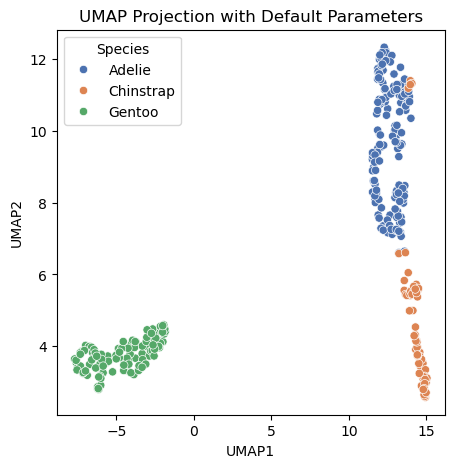

In [5]:
# Initialize UMAP with default parameters
reducer = umap.UMAP() #random_state=42 #n_epochs=50

# Fit and transform the data
embedding = reducer.fit_transform(scaled_penguin_data)


# Create a DataFrame for the embedding
embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
embedding_df['species'] = y

# Map species labels back to original names
species_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
embedding_df['species'] = embedding_df['species'].map(species_mapping)

# Plot
plt.figure(figsize=(5, 5))
sns.scatterplot(data=embedding_df, x='UMAP1', y='UMAP2', hue='species', palette='deep')
plt.title('UMAP Projection with Default Parameters')
plt.legend(title='Species')
plt.show()


In [6]:
# Define a grid of parameters
n_neighbors_list = [5, 15, 30]
min_dist_list = [0.1, 0.5, 0.99]
param_grid = [(n, d) for n in n_neighbors_list for d in min_dist_list]


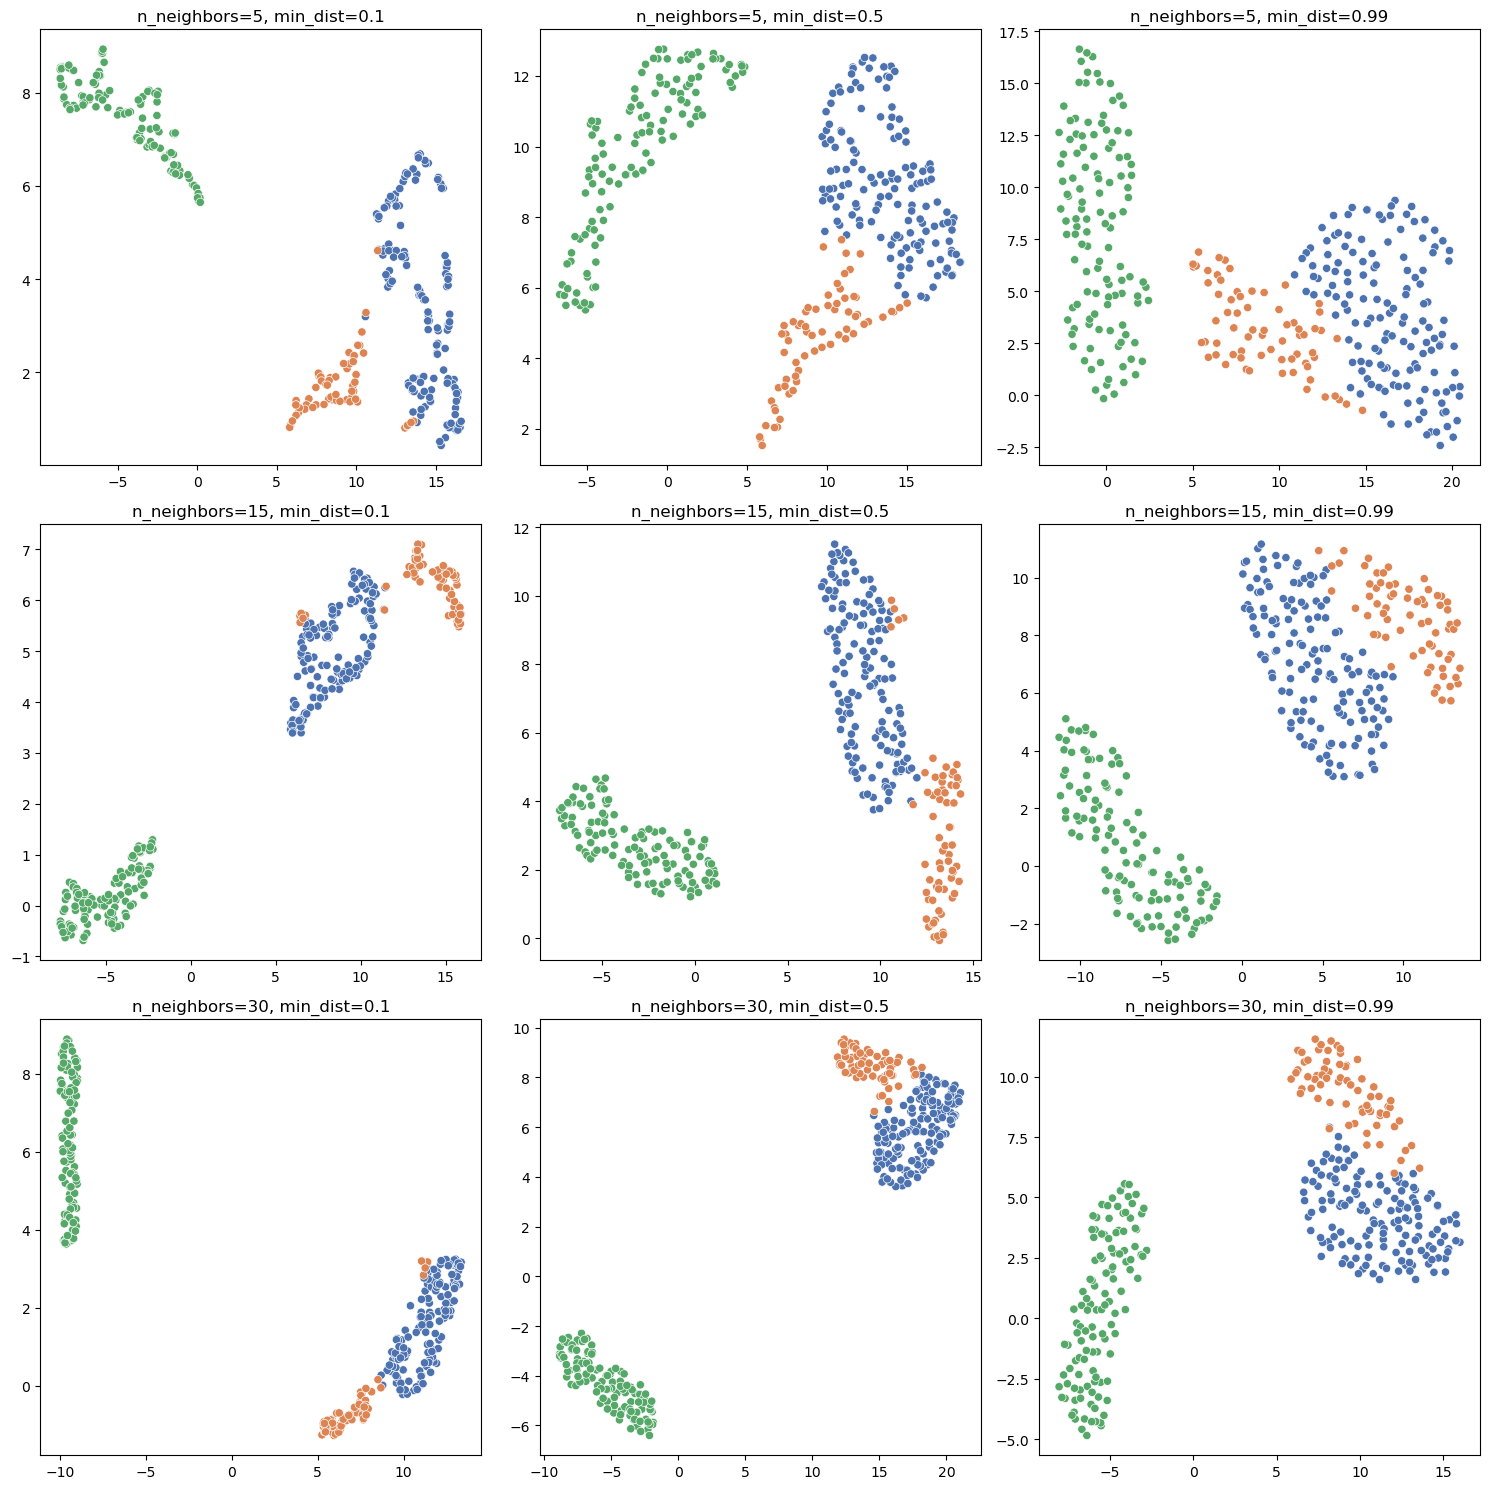

In [7]:
# Set up the plot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Iterate over parameter combinations
for i, (n_neighbors, min_dist) in enumerate(param_grid):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist)
    embedding = reducer.fit_transform(scaled_penguin_data)
    
    embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
    embedding_df['species'] = y
    embedding_df['species'] = embedding_df['species'].map(species_mapping)
    
    ax = axes[i]
    sns.scatterplot(
        data=embedding_df, x='UMAP1', y='UMAP2', hue='species',
        palette='deep', ax=ax, legend=False
    )
    ax.set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()


In [11]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'umap__n_neighbors': [5, 10, 15, 20, 25, 30],
    'umap__min_dist': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Set up the pipeline
pipeline = Pipeline([
    ('umap', umap.UMAP(random_state=42))
])

# Define the scoring function
def umap_silhouette(estimator, X):
    embedding = estimator.fit_transform(X)
    score = silhouette_score(embedding, y)
    return score

# Set up GridSearchCV
grid_search = GridSearchCV(
    pipeline, param_grid, scoring=umap_silhouette, cv=3, verbose=2, n_jobs=-1
)


In [12]:
# Fit the GridSearchCV
grid_search.fit(scaled_penguin_data)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\sabba\.conda\envs\myenv\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\sabba\.conda\envs\myenv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


GridSearchCV(cv=3, estimator=Pipeline(steps=[('umap', UMAP(random_state=42))]),
             n_jobs=-1,
             param_grid={'umap__min_dist': [0.1, 0.3, 0.5, 0.7, 0.9],
                         'umap__n_neighbors': [5, 10, 15, 20, 25, 30]},
             scoring=<function umap_silhouette at 0x000001F5A3451C60>,
             verbose=2)

In [13]:
print("Best Parameters:")
print(grid_search.best_params_)


Best Parameters:
{'umap__min_dist': 0.1, 'umap__n_neighbors': 5}


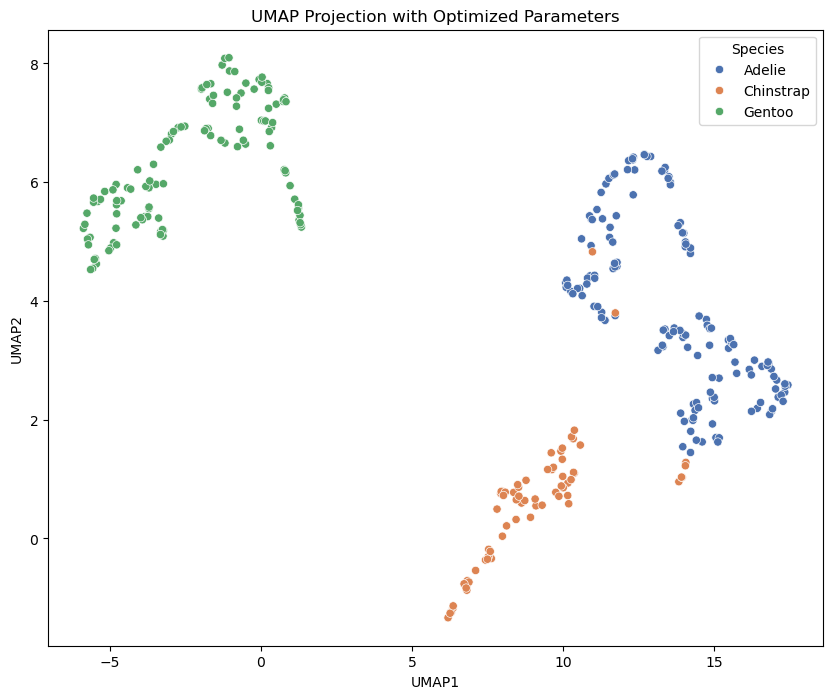

In [17]:
# Retrieve the best estimator
best_umap = grid_search.best_estimator_.named_steps['umap']

# Transform the data
best_embedding = best_umap.transform(scaled_penguin_data)

# Create a DataFrame for the embedding
best_embedding_df = pd.DataFrame(best_embedding, columns=['UMAP1', 'UMAP2'])
best_embedding_df['species'] = y
best_embedding_df['species'] = best_embedding_df['species'].map(species_mapping)


# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=best_embedding_df, x='UMAP1', y='UMAP2', hue='species', palette='deep')
plt.title('UMAP Projection with Optimized Parameters')
plt.legend(title='Species')
plt.show()
